In [ ]:
!pip install emoji
!pip install tweet-preprocessor
!pip install nltk
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 1.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Attention , Concatenate
from keras.callbacks import EarlyStopping
from keras.utils import plot_model

In [ ]:
# Define the file paths in the Colab environment
file_path = '/content/Constraint_Train.csv'
val_file_path = '/content/Constraint_Val.csv'
test_file_path = '/content/Constraint_Test.csv'

try:
    # Load CSV datasets
    data = pd.read_csv(file_path)
    val_data = pd.read_csv(val_file_path)
    test_data = pd.read_csv(test_file_path)
    print("Datasets loaded successfully.")


except FileNotFoundError:
    print("File not found.")
except Exception as e:
    print("An unexpected error occurred:", e)

Datasets loaded successfully.


In [ ]:
# Encode labels consistently in both training and validation datasets
data['label_encoded'] = data['label'].apply(lambda x: 1 if x == 'real' else 0)
val_data['label_encoded'] = val_data['label'].apply(lambda x: 1 if x == 'real' else 0)


In [ ]:
data.shape, val_data.shape

((6420, 4), (2140, 4))

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import preprocessor as p
import re

def preprocess_text(text):
    # Lowercase the text
    text = text.lower()

    # Use tweet-preprocessor to remove URLs, mentions, hashtags, and emojis
    text = p.clean(text)

    # Remove punctuation except for numbers
    text = re.sub(r'[^\w\s\d]|_', '', text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    # Join the tokens back into a single string
    preprocessed_text = ' '.join(lemmatized_tokens)

    return preprocessed_text

# Applying text preprocessing to the "tweet" column in both data and val_data
data['tweet'] = data['tweet'].apply(preprocess_text)
val_data['tweet'] = val_data['tweet'].apply(preprocess_text)

print("Preprocessed Data:")
print(data.head())

print("\nPreprocessed Validation Data:")
print(val_data.head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Preprocessed Data:
   id                                              tweet label  label_encoded
0   1  cdc currently report death general discrepancy...  real              1
1   2  state reported death small rise last tuesday s...  real              1
2   3  politically correct woman almost us pandemic e...  fake              0
3   4    testing laboratory india th august test done dg  real              1
4   5  populous state generate large case count look ...  real              1

Preprocessed Validation Data:
   id                                              tweet label  label_encoded
0   1  chinese converting islam realising muslim affe...  fake              0
1   2  people diamond princess cruise ship intially t...  fake              0
2   3     covid19 caused bacterium virus treated aspirin  fake              0
3   4  mike penny rnc speech praise donald trump covi...  fake              0
4   5  10 sky explains latest data government announc...  real              1


In [ ]:
# Reorder the labels in the validation dataset to match the order in the training dataset
val_data['label'] = val_data['label'].map({'real': 'real', 'fake': 'fake'})

# Check the unique labels and class distribution in the validation data after reordering
print("Unique labels in validation data after reordering:", val_data['label'].unique())
print("Class Distribution in validation data after reordering:")
print(val_data['label'].value_counts())

Unique labels in validation data after reordering: ['fake' 'real']
Class Distribution in validation data after reordering:
real    1120
fake    1020
Name: label, dtype: int64


In [ ]:
# Check the encoding of the target variable
print("Unique labels in training data:", data['label'].unique())

# Check the class distribution in training data
print("Class Distribution in training data:")
print(data['label'].value_counts())

# Check the encoding of the target variable in validation data
print("\nUnique labels in validation data:", val_data['label'].unique())

# Check the class distribution in validation data
print("Class Distribution in validation data:")
print(val_data['label'].value_counts())


Unique labels in training data: ['real' 'fake']
Class Distribution in training data:
real    3360
fake    3060
Name: label, dtype: int64

Unique labels in validation data: ['fake' 'real']
Class Distribution in validation data:
real    1120
fake    1020
Name: label, dtype: int64


In [ ]:
# Check the unique labels in the training data
unique_labels_train = data['label'].unique()
print("Unique labels in training data:", unique_labels_train)

# Check the unique labels in the validation data
unique_labels_val = val_data['label'].unique()
print("Unique labels in validation data:", unique_labels_val)

# Compare the order of unique labels between training and validation data
if unique_labels_train.tolist() != unique_labels_val.tolist():
    print("The order of unique labels differs between training and validation data.")
else:
    print("The order of unique labels is consistent between training and validation data.")


Unique labels in training data: ['real' 'fake']
Unique labels in validation data: ['fake' 'real']
The order of unique labels differs between training and validation data.


In [ ]:
# Tokenize and pad sequences
max_words = 10000
maxlen = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data['tweet'])
X_train = tokenizer.texts_to_sequences(data['tweet'])
X_train = pad_sequences(X_train, maxlen=maxlen)

X_val = tokenizer.texts_to_sequences(val_data['tweet'])
X_val = pad_sequences(X_val, maxlen=maxlen)

Epoch 1/25
201/201 [==============================] - 23s 105ms/step - loss: 0.3783 - accuracy: 0.8539 - val_loss: 0.1998 - val_accuracy: 0.9210
Epoch 2/25
201/201 [==============================] - 20s 97ms/step - loss: 0.1110 - accuracy: 0.9611 - val_loss: 0.1916 - val_accuracy: 0.9265
Epoch 3/25
201/201 [==============================] - 22s 108ms/step - loss: 0.0353 - accuracy: 0.9905 - val_loss: 0.2225 - val_accuracy: 0.9220
Epoch 4/25
201/201 [==============================] - 21s 107ms/step - loss: 0.0135 - accuracy: 0.9974 - val_loss: 0.2538 - val_accuracy: 0.9204
Epoch 5/25
201/201 [==============================] - 22s 110ms/step - loss: 0.0065 - accuracy: 0.9991 - val_loss: 0.2765 - val_accuracy: 0.9187
Epoch 6/25
201/201 [==============================] - 20s 101ms/step - loss: 0.0039 - accuracy: 0.9995 - val_loss: 0.2946 - val_accuracy: 0.9173
Epoch 7/25
201/201 [==============================] - 19s 95ms/step - loss: 0.0025 - accuracy: 0.9998 - val_loss: 0.3102 - val_accu

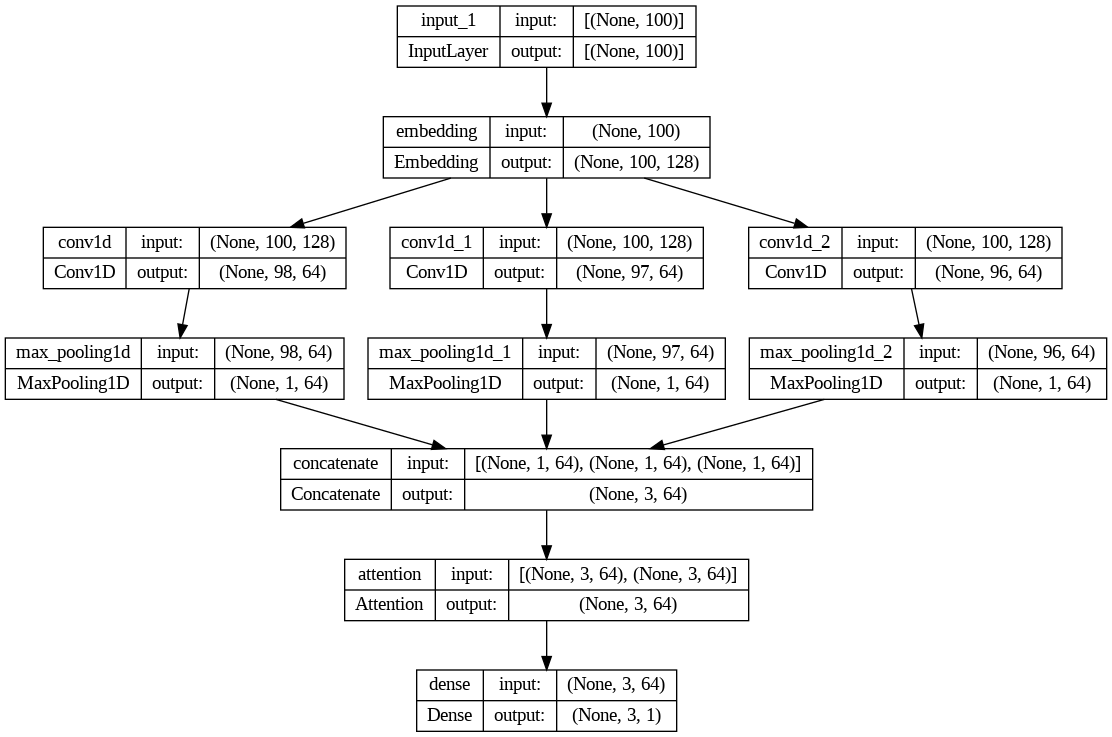

In [12]:
# Define model architecture
embedding_dim = 128
num_filters = 64
kernel_sizes = [3, 4, 5]

inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=maxlen)(inputs)
conv_layers = []
for kernel_size in kernel_sizes:
    conv_layer = Conv1D(num_filters, kernel_size, activation='relu')(embedding_layer)
    maxpool_layer = MaxPooling1D(pool_size=maxlen - kernel_size + 1)(conv_layer)
    conv_layers.append(maxpool_layer)

concatenated_tensor = Concatenate(axis=1)(conv_layers)
attention_output = Attention()([concatenated_tensor, concatenated_tensor])  
outputs = Dense(1, activation='sigmoid')(attention_output)

model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
# Train the model with early stopping
history = model.fit(X_train, data['label_encoded'], epochs=25, batch_size=32,
                    validation_data=(X_val, val_data['label_encoded']))
# history = model.fit(X_train, data['label_encoded'], epochs=50, batch_size=32,
#                     validation_data=(X_val, val_data['label_encoded']),
#                     callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_val, val_data['label_encoded'])
print("Validation accuracy:", accuracy)

plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)



In [17]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# true labels and predicted probabilities from your dataset
true_labels = val_data['label_encoded']  
predicted_probabilities = model.predict(X_val)  

# Threshold the predicted probabilities to obtain binary predictions
predicted_labels = (predicted_probabilities > 0.5).astype(int)

# Flatten the predicted labels array
predicted_labels_flattened = predicted_labels.flatten()

# Reshape the predicted labels array to match the shape of the true labels array
predicted_labels_reshaped = predicted_labels_flattened[:len(true_labels)]

# Compute precision, recall, and F1 score using scikit-learn functions
precision = precision_score(true_labels, predicted_labels_reshaped)
recall = recall_score(true_labels, predicted_labels_reshaped)
f1 = f1_score(true_labels, predicted_labels_reshaped)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


67/67 [==============================] - 1s 16ms/step
Precision: 0.5333904109589042
Recall: 0.55625
F1 Score: 0.5445804195804196


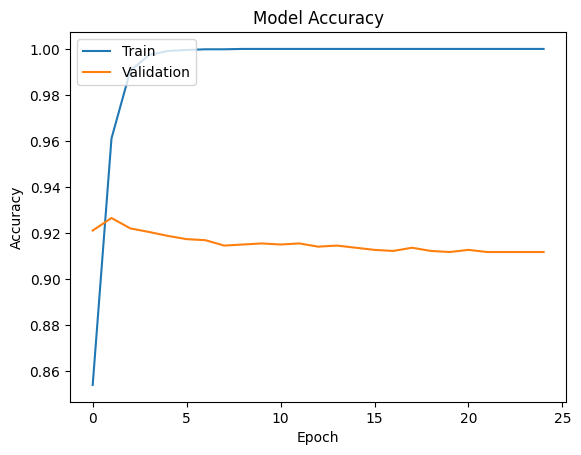

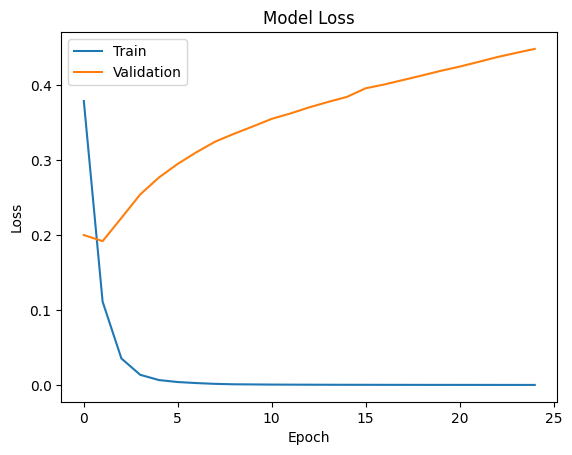

In [18]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')




Mounted at /content/drive


In [ ]:
# Save entire model
model.save('/content/drive/MyDrive/my_model.h5')

# Save weights only
model.save_weights('/content/drive/MyDrive/my_model_weights.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Your input text
input_text = "The NBA is poised to restart this month. In March we reported on how the Utah Jazz got 58 coronavirus tests in a matter of hours at a time when U.S. testing was sluggish. https://t.co/I8YjjrNoTh https://t.co/o0Nk6gpyos"

# Preprocess the text
preprocessed_text = preprocess_text(input_text)

# Tokenize and pad the text
sequence = tokenizer.texts_to_sequences([preprocessed_text])
padded_sequence = pad_sequences(sequence, maxlen=maxlen)

# Load the model weights
model.load_weights("/content/drive/MyDrive/my_model_weights.h5")

prediction = model.predict(padded_sequence)

threshold = 0.8  

if prediction[0][0] > threshold:
    print("The text is classified as positive: True")
else:
    print("The text is classified as negative: False")


1/1 [==============================] - 0s 21ms/step
The text is classified as negative: False


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle

# Save the model to a file
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)